In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier

In [7]:
Xtrain = pd.read_csv("x_train.csv",index_col=0)
Ytrain = pd.read_csv("y_train.csv",index_col=0)
Xtest = pd.read_csv("x_test.csv",index_col=0)

In [3]:
n,m = Xtrain.shape
ntest,mtest = Xtest.shape

## Neuron_id commun xtrain et xtest

In [4]:
s1 = set(Xtrain["neuron_id"])
s2 = set(Xtest["neuron_id"])
for id in s1.intersection(s2):
    print (f"neuron id : {id}")
    print(" train :", Xtrain.query(f"neuron_id=={id}")["neuron_id"].count()/n)
    print (" test :", Xtest.query(f"neuron_id=={id}")["neuron_id"].count()/ntest)

neuron id : 8046
 train : 0.003486624586714758
 test : 0.06909516250313309


Un seul neuron_id en commun entre Xtrain et Xtest, et pas présent dans les mêmes proportions. Donc on supprime la colonne neuron_id.

In [5]:
Xtrain.drop(columns=["neuron_id"],inplace=True)
Xtest.drop(columns=["neuron_id"],inplace=True)
m -= 1
mtest -= 1

## Répartition des individus en fonction de leur classe

In [6]:
ind0 = Ytrain.query('TARGET==0').index
ind1 = Ytrain.query('TARGET==1').index

n0 = len(ind0)
n1 = len(ind1)

print(f"prop 0 : {n0/n:.2g}, prop 1 : {n1/n:.2g}")

df0 = Xtrain.iloc[ind0]
df1 = Xtrain.iloc[ind1]

prop 0 : 0.82, prop 1 : 0.18


Beaucoup plus d'individus classés 0, les données sont déséquilibrées

Représentation des 10 premiers signaux pour chaque groupe

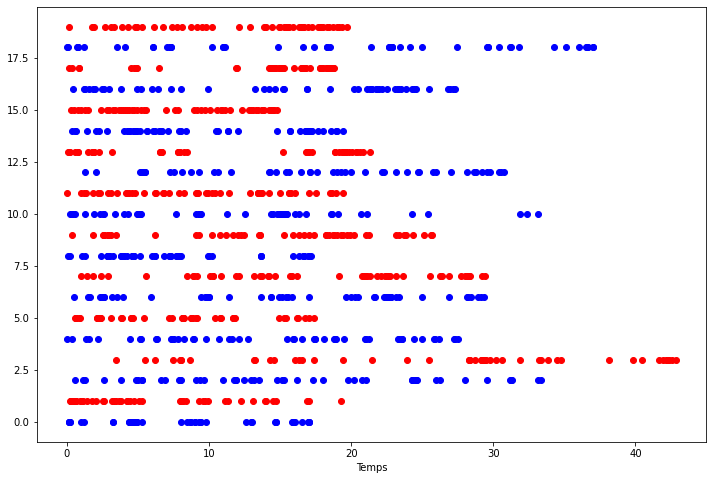

In [7]:
plt.figure(figsize=(12, 8))
x = np.arange(m)
for i in range(0,20,2):
    plt.scatter(df0.iloc[i],i*np.ones(m),color='b')
    plt.scatter(df1.iloc[i],(i+1)*np.ones(m),color='r')
plt.xlabel("Temps")
plt.show()

Pas de différences notables entre les deux classes.

# Différenciation

Calcule l'écart de temps entre un nombre de pics consécutifs passé en paramètre.

In [8]:
def diff(df,ord):
    m = df.shape[1]
    dif = pd.DataFrame()
    dif[0] = df.iloc[:,(ord-1)]
    for i in range(m-ord):
        dif[i+1] = df.iloc[:,i+ord]-df.iloc[:,i]
    dif.index = df.index
    return dif

Différenciation à l'ordre 1 : calcul de l'écart entre deux pics consécutifs

In [9]:
Xtrain_1 = diff(Xtrain,1)
Xtrain_1.head(5)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
ID,,,,,,,,,,,,,,,,,,,,,
0,0.166262,0.004258,0.005851,0.021194,0.015249,0.744817,0.220048,2.029589,0.006334,1.138758,...,0.023318,1.155765,0.049883,0.004133,0.169155,0.436473,0.472676,0.007250,0.023887,0.036415
1,0.053270,0.080382,0.027950,0.368929,0.162005,0.037755,0.053775,0.239245,0.035892,0.012870,...,0.027535,1.157579,6.492402,0.755862,0.422487,0.291182,0.183752,0.254982,0.074063,0.071353
2,0.600593,0.526874,0.162346,1.308847,1.228051,1.024309,0.174702,0.236532,0.020661,1.324287,...,0.051216,1.332046,0.303601,1.757755,1.556321,1.598413,0.034828,0.067691,1.875161,0.200009
3,0.136037,0.519697,0.336779,0.498451,0.755861,0.608494,0.352735,0.117038,0.877016,0.988270,...,0.008387,0.214713,0.339685,0.150340,0.605092,0.367997,0.851724,0.279529,0.966659,0.010066
4,0.200614,0.056557,0.030966,0.025940,0.172825,0.012688,0.035370,0.089025,0.015327,0.252605,...,0.185276,0.916400,0.857890,0.879943,0.061384,0.462134,0.248058,2.159646,0.168545,2.237582


In [10]:
Xtest_1 = diff(Xtest,1)
Xtest_1.head(5)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
ID,,,,,,,,,,,,,,,,,,,,,
16635,0.011162,0.209906,0.209521,0.071795,0.176242,0.343373,0.178515,0.295627,2.162661,0.297823,...,1.402280,0.085091,5.919577,3.097085,0.285011,1.790428,1.263509,3.787726,8.290187,0.038497
16636,0.461402,0.656876,0.590462,0.009371,0.005092,0.268867,0.211066,0.161642,0.510456,0.154107,...,0.080638,0.011481,0.006279,0.372661,1.284278,0.394198,0.057033,1.788264,0.380003,0.115829
16637,0.483416,0.091549,1.585858,0.110896,0.071187,0.542740,0.100072,0.073698,0.415311,0.030382,...,0.051218,0.041921,0.138303,0.886382,0.614442,0.520117,0.155096,0.809807,1.378007,1.208458
16638,0.008057,0.856605,0.746032,0.324951,0.012032,1.079402,0.210785,0.037427,0.025324,0.005467,...,0.346384,0.616553,0.049366,0.115343,0.010579,0.456075,0.186098,0.255518,0.350189,0.142385
16639,5.815709,1.850684,0.342631,0.018195,2.174404,0.048210,0.608654,0.007155,0.854837,0.375030,...,0.112346,0.024983,0.006117,0.009336,0.988286,0.177824,0.182890,0.014678,0.063575,0.033337


Vecteur temps inter-pic pour l'ensembles des individus du groupe 0 et 1

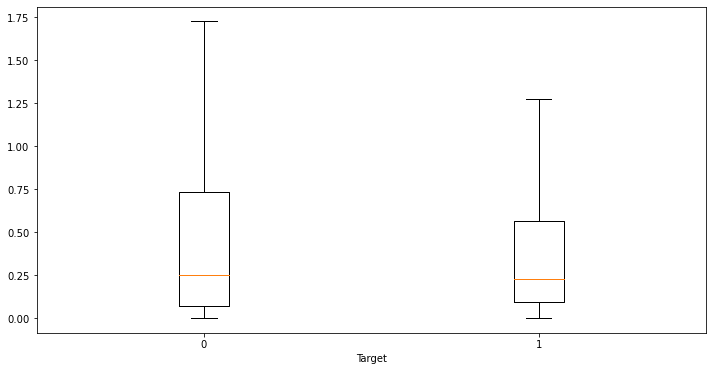

In [12]:
V0 = Xtrain_1.iloc[ind0].to_numpy().flatten()
V1 = Xtrain_1.iloc[ind1].to_numpy().flatten()
plt.figure(figsize=(12, 6))
plt.boxplot(V0,showfliers=False,positions=[0])
plt.boxplot(V1,showfliers=False,positions=[1])
plt.xlabel("Target")
plt.show()

La mediane et les quantiles d'ordres faibles ont une valeurs proches dans les deux groupes. En revanche, la différence entre les quantiles d'ordres élévés est plus importante.

Comparaison des différents quantiles pour chaque groupe

In [13]:
quantiles = np.linspace(0.05,0.95,19)

Q0 = np.quantile(V0,q=quantiles)
Q1 = np.quantile(V1,q=quantiles)

dfq = pd.DataFrame(np.c_[Q0,Q1,abs(Q0-Q1)])
dfq.columns = ['Target = 0', 'Target = 1',"|ecart|"]
dfq.index = [f"{q:.2g}" for q in quantiles]
dfq

,Target = 0,Target = 1,|ecart|
0.05,0.012401,0.018682,0.006280
0.1,0.020968,0.032162,0.011194
0.15,0.032944,0.049205,0.016262
0.2,0.049712,0.069650,0.019938
0.25,0.071655,0.092627,0.020972
0.3,0.098048,0.116624,0.018576
0.35,0.128189,0.141476,0.013287
0.4,0.163115,0.167396,0.004281
0.45,0.203218,0.196274,0.006943
0.5,0.252432,0.228959,0.023472


Plus grand écart entre les quantiles de valeurs élévés

# Introduction de nouvelles variables

## Indicateurs Statistiques sur les différenciation d'ordre 1 par individu

In [14]:
def Indiv_df(df):
    df_stats = pd.DataFrame()
    df_stats["Min"] = df.min(axis=1)
    df_stats["Mean"] = df.mean(axis=1)
    df_stats["Max"] = df.max(axis=1)
    df_stats["Std"] = df.std(axis=1)
    quantiles=[0.05,0.15,0.25,0.5,0.75,0.85,0.95]
    for i in quantiles:
        df_stats[f"Qi_{i:.2g}"] = df.quantile(q=i,axis=1)
    df_stats.index = df.index
    return(df_stats)

In [15]:
df_indiv_train = Indiv_df(Xtrain_1)
df_indiv_train.head(5)

,Min,Mean,Max,Std,Qi_0.05,Qi_0.15,Qi_0.25,Qi_0.5,Qi_0.75,Qi_0.85,Qi_0.95
ID,,,,,,,,,,,
0,0.004133,0.341128,2.838052,0.654644,0.005319,0.007860,0.014097,0.065681,0.328098,0.460422,1.856335
1,0.008825,0.402474,6.492402,0.944283,0.012355,0.025339,0.053396,0.186008,0.365118,0.490178,1.183569
2,0.014021,0.667219,3.185310,0.666855,0.027036,0.063152,0.165435,0.359982,1.090869,1.325181,1.765076
3,0.004493,0.345192,1.077179,0.299719,0.008717,0.015407,0.099267,0.300643,0.515438,0.705640,0.926319
4,0.012688,0.385798,2.653620,0.571187,0.017000,0.041005,0.078566,0.192945,0.339710,0.737590,1.729201


In [16]:
df_indiv_test = Indiv_df(Xtest_1)
df_indiv_test.head(5)

,Min,Mean,Max,Std,Qi_0.05,Qi_0.15,Qi_0.25,Qi_0.5,Qi_0.75,Qi_0.85,Qi_0.95
ID,,,,,,,,,,,
16635,0.002036,0.685040,8.290187,1.554747,0.010225,0.018383,0.035056,0.100902,0.297274,1.142469,3.476938
16636,0.004059,0.341569,1.788264,0.401132,0.004696,0.010109,0.048502,0.182472,0.498192,0.719833,1.136267
16637,0.023854,0.482523,1.856078,0.492765,0.040996,0.064175,0.086019,0.219786,0.858326,1.069469,1.340403
16638,0.005467,0.398588,2.160881,0.435793,0.008149,0.029560,0.096078,0.325224,0.506683,0.715471,1.241411
16639,0.004355,0.591000,5.815709,1.152229,0.005572,0.008251,0.013775,0.060043,0.558847,1.440047,2.713385


## Statistiques descriptives ordre 2, 5 et 10

In [17]:
def stat_dif(df,m):
    df_m = diff(df,m)
    df_stats = pd.DataFrame()
    df_stats[f"Min_{m}"] = df_m.min(axis=1)
    df_stats[f"Q1_{m}"] = df_m.quantile(q=0.25,axis=1)
    df_stats[f"Mean_{m}"] = df_m.mean(axis=1)
    df_stats[f"Q3_{m}"] = df_m.quantile(q=0.75,axis=1)
    df_stats[f"Max_{m}"] = df_m.max(axis=1)
    df_stats[f"Std_{m}"] = df_m.std(axis=1)
    df_stats.index = df.index
    return(df_stats)

In [18]:
df_2_train = stat_dif(Xtrain, 2)
df_5_train = stat_dif(Xtrain, 5)
df_10_train = stat_dif(Xtrain, 10)

df_dif_train = df_2_train.join(df_5_train)
df_dif_train = df_dif_train.join(df_10_train)

df_dif_train.head(5)

,Min_2,Q1_2,Mean_2,Q3_2,Max_2,Std_2,Min_5,Q1_5,Mean_5,Q3_5,Max_5,Std_5,Min_10,Q1_10,Mean_10,Q3_10,Max_10,Std_10
ID,,,,,,,,,,,,,,,,,,
0,0.010109,0.060302,0.692043,0.964865,3.182750,0.927875,0.128017,0.639181,1.823191,3.308300,5.227446,1.528727,0.289776,3.392740,3.745165,4.498527,6.563546,1.805162
1,0.032405,0.197088,0.818833,0.713668,7.649981,1.479658,0.256094,0.706537,2.142134,1.908210,9.658545,2.531859,1.072073,2.015744,4.204652,4.069738,12.516662,3.700478
2,0.065237,0.581269,1.345332,1.942852,3.510867,0.903164,0.373703,2.553867,3.360706,4.180931,6.548137,1.290246,4.306131,5.280222,6.459275,7.277973,9.468742,1.457194
3,0.011933,0.400671,0.701492,0.973089,2.065450,0.460979,0.435204,1.052186,1.710256,2.328143,3.686608,0.885915,1.673754,2.242657,3.243587,4.075502,6.265817,1.402627
4,0.048058,0.257171,0.737585,0.941327,2.892825,0.750906,0.245965,0.968111,1.768833,2.780119,5.275965,1.236433,0.871023,2.141995,3.491068,4.571227,8.176857,1.777444


In [19]:
df_2_test = stat_dif(Xtest, 2)
df_5_test = stat_dif(Xtest, 5)
df_10_test = stat_dif(Xtest, 10)

df_dif_test=df_2_test.join(df_5_test)
df_dif_test=df_dif_test.join(df_10_test)

df_dif_test.head(5)

,Min_2,Q1_2,Mean_2,Q3_2,Max_2,Std_2,Min_5,Q1_5,Mean_5,Q3_5,Max_5,Std_5,Min_10,Q1_10,Mean_10,Q3_10,Max_10,Std_10
ID,,,,,,,,,,,,,,,,,,
16635,0.011496,0.118050,1.397028,1.477352,12.077914,2.549783,0.114149,0.308352,2.961551,3.247604,15.416862,4.286040,0.345875,1.462455,4.908000,4.714769,25.995968,6.306486
16636,0.014463,0.273959,0.685299,0.985284,2.168267,0.543889,0.494035,1.079649,1.633671,1.999841,3.903776,0.796663,1.609403,2.556948,3.156754,3.759088,4.973172,0.880046
16637,0.084167,0.335230,0.950213,1.355809,2.586464,0.687889,0.375042,1.338096,2.269506,2.961016,5.589177,1.178932,1.693234,2.689543,4.499678,6.365160,8.105122,2.005221
16638,0.016822,0.440449,0.810374,0.989437,2.674553,0.630548,0.817462,1.250553,2.019797,2.842589,5.162848,1.068279,1.977020,2.733154,4.139369,4.843574,7.308441,1.509727
16639,0.010039,0.057246,1.086753,1.606270,7.666392,1.609217,0.026625,0.324918,2.558592,4.250321,10.201623,2.297916,0.189289,1.590203,5.004126,7.664361,12.095508,3.376161


## Comparaison avec les indicateurs statistiques par groupe

Pour chaque individu, compte le nombre d'observations supérieures à la moyenne, à la mediane et aux quantiles à (75%, 95%), ainsi que le nombre d'observations inférieures aux quantiles (5%,25%) de l'ensemble des obserations du groupe 0 et du groupe 1.

In [20]:
def Groupe_df(df,Xt=Xtrain_1,Yt=Ytrain):
    
    df_grp = pd.DataFrame()
    
    n = df.shape[0]
    
    quant = [0.1,0.25,0.75,0.9]
    # Indiv classé 0 dans Xtrain
    ind0 = Yt.query('TARGET==0').index
    V0 = Xt.iloc[ind0].to_numpy().flatten()
    Q0 = np.quantile(V0,q=quant)
    
    # Indiv classé 1 dans Xtrain
    ind1 = Yt.query('TARGET==1').index
    V1 = Xt.iloc[ind1].to_numpy().flatten()
    Q1 = np.quantile(V1,q=quant)
    
    for j in range(4):
        df_grp[f"Q0_{quant[j]}"] = [len(np.where(df.iloc[i]>Q0[j])[0]) for i in range (n)]
        df_grp[f"Q1_{quant[j]}"] = [len(np.where(df.iloc[i]>Q1[j])[0]) for i in range (n)]
    df_grp.index = df.index
    return(df_grp)

In [22]:
df_grp_train = Groupe_df(Xtrain_1)
df_grp_train.head(5)

,Q0_0.1,Q1_0.1,Q0_0.25,Q1_0.25,Q0_0.75,Q1_0.75,Q0_0.9,Q1_0.9
ID,,,,,,,,
0,35,29,23,21,7,7,4,4
1,45,40,34,30,6,7,2,2
2,47,47,41,40,18,22,6,11
3,41,40,39,38,8,12,0,0
4,46,43,38,35,8,8,3,3


In [23]:
df_grp_test = Groupe_df(Xtest_1)
df_grp_test.head(5)

,Q0_0.1,Q1_0.1,Q0_0.25,Q1_0.25,Q0_0.75,Q1_0.75,Q0_0.9,Q1_0.9
ID,,,,,,,,
16635,41,39,32,27,10,11,6,8
16636,40,39,33,31,8,10,1,3
16637,50,48,39,35,15,17,2,4
16638,43,42,38,38,8,11,2,3
16639,32,31,24,24,11,13,6,9


## Régression linéaire

In [24]:
def graph_reglin(ind,df):
    x = np.array(df.iloc[ind,:-1]).reshape(-1,1)
    y = df.iloc[ind,1:]
    
    LR = LinearRegression()
    LR.fit(x,y)
    a = LR.coef_[0]
    b = LR.intercept_
    
    t = np.linspace(x[0],y[-1])
    plt.plot(x,y,'b')
    plt.plot(t,a*t+b,'r')
    
    plt.xlabel("X(t)")
    plt.ylabel("X(t+1)")
    plt.title(f"Regression lineaire individu {Xtrain.iloc[ind].name} ")

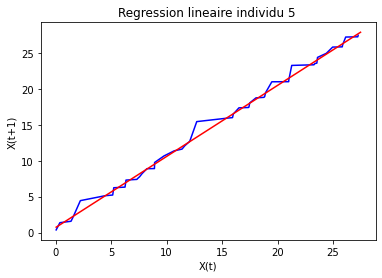

In [25]:
graph_reglin(5,Xtrain)

In [26]:
def df_reglin(df):
    dico = defaultdict(list)
    n = df.shape[0]
    for i in range (n):
        LR = LinearRegression()
        x = np.array(df.iloc[i,:-1]).reshape(-1,1)
        y = df.iloc[i,1:]
        LR.fit(x,y)
        dico["c1"].append(LR.coef_[0])
        dico["c0"].append(LR.intercept_)
        dico["LR_score"].append(LR.score(x,y))
    df_reglin = pd.DataFrame(dico, index=df.index)
    return df_reglin

In [27]:
df_reglin_train = df_reglin(Xtrain)
df_reglin_train.head(5)

,c1,c0,LR_score
ID,,,
0,0.998964,0.352888,0.985349
1,1.025497,0.241984,0.977476
2,1.007058,0.559692,0.994857
3,0.981200,0.526766,0.995588
4,1.048270,0.097405,0.990297


In [28]:
df_reglin_test = df_reglin(Xtest)
df_reglin_test.head(5)

,c1,c0,LR_score
ID,,,
16635,1.110742,-0.157429,0.968742
16636,1.005034,0.298462,0.991847
16637,1.025487,0.236785,0.995024
16638,0.984040,0.582951,0.995294
16639,0.958774,1.366273,0.987170


## Calcul du nombre max, moyenne et écart-type de pics pour une unité de temps

In [29]:
def ParUnite(df):
    n,m = df.shape
    stock_mean = []
    stock_max = []
    stock_std = []
    for i in range (n):
        L = [len(np.where(df.iloc[i,:]<1)[0])]
        L += [len(np.where(df.iloc[i,(j+1):]<1+df.iloc[i,j])[0])for j in range (m)]
        stock_mean.append(np.mean(L))
        stock_max.append(max(L))
        stock_std.append(np.std(L))
    df_ut = pd.DataFrame(np.c_[stock_mean,stock_max,stock_std],columns=('Mean_ut','Max_ut','Std_ut'), index=df.index)
    return(df_ut)

In [31]:
df_ut_train=ParUnite(Xtrain)
df_ut_train.head(5)

,Mean_ut,Max_ut,Std_ut
ID,,,
0,4.176471,15.0,3.797346
1,3.705882,9.0,2.427733
2,1.215686,5.0,1.142988
3,2.960784,7.0,1.770796
4,3.490196,11.0,2.739490


In [30]:
df_ut_test = ParUnite(Xtest)
df_ut_test.head(5)

,Mean_ut,Max_ut,Std_ut
ID,,,
16635,5.098039,16.0,5.014703
16636,2.725490,8.0,1.847929
16637,1.980392,6.0,1.514508
16638,2.411765,5.0,1.430432
16639,3.607843,15.0,3.926174


## Calcul de fréquence : nombre de saut par unité de temps

In [32]:
def df_freq(df):
    n,m = df.shape
    dico = defaultdict(list)
    for i in range(n):
        freq = [(k+1)/df.iloc[i,k] for k in range(m)]
        for j in range(m-1):
            nb_saut= np.arange(1,m-j)
            tps = df.iloc[i,(j+1):] - df.iloc[i,j]
            freq += list(nb_saut/tps)
        dico["freq_min"].append(min(freq))
        dico["freq_q1"].append(np.quantile(freq,q=0.25)) 
        dico["freq_mean"].append(np.mean(freq))
        dico["freq_q3"].append(np.quantile(freq,q=0.75))
        dico["freq_max"].append(max(freq))
        dico["freq_std"].append(np.std(freq))
    df_freq = pd.DataFrame(dico, index=df.index)
    return df_freq

In [33]:
df_freq_train = df_freq(Xtrain)
df_freq_train.head(5)

,freq_min,freq_q1,freq_mean,freq_q3,freq_max,freq_std
ID,,,,,,
0,0.352354,2.241230,7.623908,3.979555,241.971649,19.423931
1,0.154026,2.111140,4.511283,4.645994,113.319481,6.686931
2,0.313941,1.387725,2.021894,1.802788,71.321277,3.627910
3,0.928350,2.737550,4.704633,4.330145,222.564462,11.388472
4,0.376844,2.354079,4.318199,4.214654,78.811648,5.414014


In [34]:
df_freq_test = df_freq(Xtest)
df_freq_test.head(5)

,freq_min,freq_q1,freq_mean,freq_q3,freq_max,freq_std
ID,,,,,,
16635,0.120625,1.915668,7.448633,7.023175,491.045073,17.920443
16636,0.559202,2.867848,5.262444,3.669528,246.372141,16.199900
16637,0.538771,1.761791,2.984005,3.297587,41.921052,2.804892
16638,0.462774,2.030062,3.657988,2.987769,182.906641,10.457393
16639,0.171948,1.416914,10.406526,3.617716,229.627315,28.951955


## Jointure des DataFrames

In [36]:
df_train = df_indiv_train.join(df_grp_train)
df_train = df_train.join(df_ut_train)
df_train = df_train.join(df_dif_train)
df_train = df_train.join(df_freq_train)
df_train = df_train.join(df_reglin_train)
df_train.head(5)

,Min,Mean,Max,Std,Qi_0.05,Qi_0.15,Qi_0.25,Qi_0.5,Qi_0.75,Qi_0.85,...,Std_10,freq_min,freq_q1,freq_mean,freq_q3,freq_max,freq_std,c1,c0,LR_score
ID,,,,,,,,,,,,,,,,,,,,,
0,0.004133,0.341128,2.838052,0.654644,0.005319,0.007860,0.014097,0.065681,0.328098,0.460422,...,1.805162,0.352354,2.241230,7.623908,3.979555,241.971649,19.423931,0.998964,0.352888,0.985349
1,0.008825,0.402474,6.492402,0.944283,0.012355,0.025339,0.053396,0.186008,0.365118,0.490178,...,3.700478,0.154026,2.111140,4.511283,4.645994,113.319481,6.686931,1.025497,0.241984,0.977476
2,0.014021,0.667219,3.185310,0.666855,0.027036,0.063152,0.165435,0.359982,1.090869,1.325181,...,1.457194,0.313941,1.387725,2.021894,1.802788,71.321277,3.627910,1.007058,0.559692,0.994857
3,0.004493,0.345192,1.077179,0.299719,0.008717,0.015407,0.099267,0.300643,0.515438,0.705640,...,1.402627,0.928350,2.737550,4.704633,4.330145,222.564462,11.388472,0.981200,0.526766,0.995588
4,0.012688,0.385798,2.653620,0.571187,0.017000,0.041005,0.078566,0.192945,0.339710,0.737590,...,1.777444,0.376844,2.354079,4.318199,4.214654,78.811648,5.414014,1.048270,0.097405,0.990297


In [35]:
df_test = df_indiv_test.join(df_grp_test)
df_test = df_test.join(df_ut_test)
df_test = df_test.join(df_dif_test)
df_test = df_test.join(df_freq_test)
df_test = df_test.join(df_reglin_test)
df_test.head(5)

,Min,Mean,Max,Std,Qi_0.05,Qi_0.15,Qi_0.25,Qi_0.5,Qi_0.75,Qi_0.85,...,Std_10,freq_min,freq_q1,freq_mean,freq_q3,freq_max,freq_std,c1,c0,LR_score
ID,,,,,,,,,,,,,,,,,,,,,
16635,0.002036,0.685040,8.290187,1.554747,0.010225,0.018383,0.035056,0.100902,0.297274,1.142469,...,6.306486,0.120625,1.915668,7.448633,7.023175,491.045073,17.920443,1.110742,-0.157429,0.968742
16636,0.004059,0.341569,1.788264,0.401132,0.004696,0.010109,0.048502,0.182472,0.498192,0.719833,...,0.880046,0.559202,2.867848,5.262444,3.669528,246.372141,16.199900,1.005034,0.298462,0.991847
16637,0.023854,0.482523,1.856078,0.492765,0.040996,0.064175,0.086019,0.219786,0.858326,1.069469,...,2.005221,0.538771,1.761791,2.984005,3.297587,41.921052,2.804892,1.025487,0.236785,0.995024
16638,0.005467,0.398588,2.160881,0.435793,0.008149,0.029560,0.096078,0.325224,0.506683,0.715471,...,1.509727,0.462774,2.030062,3.657988,2.987769,182.906641,10.457393,0.984040,0.582951,0.995294
16639,0.004355,0.591000,5.815709,1.152229,0.005572,0.008251,0.013775,0.060043,0.558847,1.440047,...,3.376161,0.171948,1.416914,10.406526,3.617716,229.627315,28.951955,0.958774,1.366273,0.987170


## Standardisation des données

In [41]:
stdscal = StandardScaler()
std_train = stdscal.fit_transform(df_train)
X_train = pd.DataFrame(std_train, index=df_train.index, columns=df_train.columns)
print(f"Taille X_train : {X_train.shape}")
X_train.head(5)

Taille X_train : (16635, 49)


,Min,Mean,Max,Std,Qi_0.05,Qi_0.15,Qi_0.25,Qi_0.5,Qi_0.75,Qi_0.85,...,Std_10,freq_min,freq_q1,freq_mean,freq_q3,freq_max,freq_std,c1,c0,LR_score
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.736310,-1.379098,-0.517005,-0.415981,-0.942720,-1.155729,-1.372692,-1.643169,-1.439959,-1.654611,...,-0.577537,0.206191,0.918298,2.851546,0.720713,0.935429,2.464939,0.161283,-0.726890,-0.526274
1,-0.297202,-0.996823,1.333509,0.506838,-0.605425,-0.724030,-0.694437,-0.649970,-1.298876,-1.575824,...,0.903269,-1.097637,0.700166,0.756203,1.159666,-0.223389,-0.128753,1.275385,-0.974685,-1.376977
2,0.189127,0.652919,-0.341158,-0.377074,0.098302,0.209921,1.239216,0.786047,1.466988,0.635061,...,-0.849403,-0.046341,-0.512832,-0.919593,-0.713024,-0.601682,-0.751676,0.501157,-0.264821,0.501047
3,-0.702583,-1.353773,-1.408688,-1.546807,-0.779851,-0.969343,0.097239,0.296249,-0.726001,-1.005333,...,-0.892036,3.992842,1.750511,0.886362,0.951630,0.760621,0.828643,-0.584594,-0.338389,0.580054
4,0.064413,-1.100737,-0.610399,-0.681883,-0.382790,-0.337095,-0.260043,-0.592710,-1.395707,-0.920736,...,-0.599193,0.367186,1.107519,0.626224,0.875562,-0.534214,-0.387963,2.231628,-1.297723,0.008341


In [42]:
stdscal = StandardScaler()
std_test = stdscal.fit_transform(df_test)
X_test = pd.DataFrame(std_test, index=df_test.index, columns=df_test.columns)
print(f"Taille X_test : {X_test.shape}")
X_test.head(5)

Taille X_test : (11969, 49)


,Min,Mean,Max,Std,Qi_0.05,Qi_0.15,Qi_0.25,Qi_0.5,Qi_0.75,Qi_0.85,...,Std_10,freq_min,freq_q1,freq_mean,freq_q3,freq_max,freq_std,c1,c0,LR_score
ID,,,,,,,,,,,,,,,,,,,,,
16635,-0.771555,0.948547,2.841548,2.882115,-0.495917,-0.697425,-0.764905,-1.175795,-1.560758,0.158970,...,3.509391,-1.455773,0.221277,2.189607,2.826549,3.140814,1.367219,5.721717,-2.230248,-3.766160
16636,-0.573819,-1.217794,-0.996029,-1.175057,-0.826800,-0.976126,-0.477761,-0.504037,-0.785193,-0.991518,...,-1.205969,1.297075,1.831544,0.872112,0.530496,0.770624,1.081925,0.482083,-0.945170,0.197692
16637,1.361610,-0.328769,-0.956004,-0.852791,1.345540,0.845142,0.323423,-0.196740,0.604960,-0.039749,...,-0.228237,1.168835,-0.038951,-0.500977,0.275849,-1.209929,-1.139187,1.495855,-1.119028,0.742808
16638,-0.436121,-0.858166,-0.776102,-1.053158,-0.620200,-0.320924,0.538230,0.671585,-0.752418,-1.003391,...,-0.658802,0.691823,0.414733,-0.094805,0.063734,0.155823,0.129723,-0.558518,-0.143246,0.789060
16639,-0.544881,0.355414,1.381057,1.466491,-0.774389,-1.038726,-1.219373,-1.512290,-0.551058,0.969029,...,0.963055,-1.133627,-0.622184,3.972167,0.495022,0.608414,3.196424,-1.810903,2.064799,-0.604649


## Fonction pour affichage des resultats

In [19]:
def result(y_test,pred):
    P = np.where(y_test==1)[0]
    N = np.where(y_test==0)[0]
    TP = len(np.where(pred[P]==1)[0])
    FP = len(np.where(pred[P]==0)[0])
    TN = len(np.where(pred[N]==0)[0])
    FN = len(np.where(pred[N]==1)[0])
    return (TP,FP,TN,FN)

# Modelisation

In [14]:
X_train = pd.read_csv("DataFrame\df_train_std.csv",index_col=0)
Ytrain = pd.read_csv("y_train.csv",index_col=0)
X_test = pd.read_csv("DataFrame\df_test_std.csv",index_col=0)

## Split en echantillon train et test

In [16]:
x_train,x_test,y_train,y_test = train_test_split(X_train,Ytrain,test_size = 0.2,stratify=Ytrain)

## KNN

Pas de test sur Xtest car score de validation croisée et score sur x_test trop faible

In [14]:
pgrid  = {'n_neighbors':range(1, 25, 2)}

grid_search = GridSearchCV(KNeighborsClassifier(),  param_grid=pgrid,cv=5,scoring=make_scorer(cohen_kappa_score), n_jobs=-1)
grid_search.fit(x_train,y_train.values.ravel())
print("Best score cv :",grid_search.best_score_)
print("Parametres :",grid_search.best_params_)


best_clf = grid_search.best_estimator_
best_pred = best_clf.predict(x_test)
score_test = cohen_kappa_score(y_test,best_pred)
print("Score Test :",score_test)
print(f"(TP,FP,TN,FN) : {result(y_test,best_pred)}")

Best score cv : 0.1763961455476361
Parametres : {'n_neighbors': 3}
Score Test : 0.12777585286996673


In [122]:
clf = KNeighborsClassifier(n_neighbors = 5)
clf.fit(x_train,y_train.values.ravel())
pred = clf.predict(x_test)
score = cohen_kappa_score(y_test,pred)
print(f"cohen kappa score : {score}")
print(f"(TP,FP,TN,FN) : {result(y_test,pred)}")

cohen kappa score : 0.1451588406386286


## SVM

Meilleur score Xtest : 0.324528727847387

Parametrisation : kernel = "rbf", class_weight={0:1,1:3}

## Recherche du meilleur noyau avec les paramètres de base

In [ ]:
pgrid  = {'kernel':['rbf','poly','linear','sigmoid']}

grid_search = GridSearchCV(SVC(class_weight={0:1,1:3}),  param_grid=pgrid,cv=5, scoring=make_scorer(cohen_kappa_score), n_jobs=-1)
grid_search.fit(x_train,y_train.values.ravel())
print("Best score cv :",grid_search.best_score_)
print("Parametres :",grid_search.best_params_)


best_clf = grid_search.best_estimator_
best_pred = best_clf.predict(x_test)
score_test = cohen_kappa_score(y_test,best_pred)
print("Score Test :",score_test)
print(f"(TP,FP,TN,FN) : {result(y_test,best_pred)}")

In [18]:
clf = SVC(kernel = "rbf", class_weight={0:1,1:3})
clf.fit(x_train,y_train.values.ravel())
pred=clf.predict(x_test)
score=cohen_kappa_score(y_test,pred)
print(f"cohen kappa score : {score}")
print(f"(TP,FP,TN,FN) : {result(y_test,pred)}")

cohen kappa score : 0.33635275600878767
(TP,FP,TN,FN) : (327, 285, 2270, 445)


## Optimisation du noyau polynomial

Meilleur score : 0.317900946336248

Paramètres : kernel = "poly", class_weight={0:1,1:3}, degree=3, coef0=10

In [ ]:
pgrid  = {'coef0': np.arange(-100,100,10)}

grid_search = GridSearchCV(SVC(kernel="poly",class_weight={0:1,1:3},degree=3),  param_grid=pgrid,cv=5, scoring=make_scorer(cohen_kappa_score), n_jobs=-1)
grid_search.fit(x_train,y_train.values.ravel())
print("Best score cv :",grid_search.best_score_)
print("Parametres :",grid_search.best_params_)


best_clf = grid_search.best_estimator_
best_pred = best_clf.predict(x_test)
score_test = cohen_kappa_score(y_test,best_pred)
print("Score Test :",score_test)
print(f"(TP,FP,TN,FN) : {result(y_test,best_pred)}")

In [ ]:
clf = SVC(kernel = "poly",class_weight={0:1,1:3},degree=3,coef0=1,gamma=2)
clf.fit(x_train,y_train.values.ravel())
pred = clf.predict(x_test)
score = cohen_kappa_score(y_test,pred)
print(f"cohen kappa score : {score}")
print(f"(TP,FP,TN,FN) : {result(y_test,pred)}")

## Decision Tree

Pas de test sur Xtest car score de validation croisée et score sur x_test trop faible

In [16]:
pgrid = {"max_depth": range(1,15),
        "min_samples_split": [2, 3, 5, 10, 15, 20],
        "criterion": ["gini","entropy"]}

grid_search = GridSearchCV(DecisionTreeClassifier(class_weight={0:1,1:3}), param_grid=pgrid, cv=5,scoring=make_scorer(cohen_kappa_score), n_jobs=-1)
grid_search.fit(x_train,y_train)
print("Best score cv :",grid_search.best_score_)
print("Parametres :",grid_search.best_params_)


best_clf = grid_search.best_estimator_
best_pred = best_clf.predict(x_test)
score_test = cohen_kappa_score(y_test,best_pred)
print("Score Test :",score_test)
print(f"(TP,FP,TN,FN) : {result(y_test,best_pred)}")

Best score cv : 0.27773304839466456
Parametres : {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 20}
Score Test : 0.27442302520043393


In [119]:
clf = DecisionTreeClassifier( max_depth = 5 ,min_samples_split=2, criterion='entropy',class_weight={0: 1, 1: 3})
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
score = cohen_kappa_score(y_test,pred)
print(f"cohen kappa score : {score}")
print(f"(TP,FP,TN,FN) : {result(y_test,pred)}")

cohen kappa score : 0.23344587170625475


## Random Forest

Meilleur score Xtest : 0.3420709307705211 (Meilleur score)

n_estimators = 150 , max_depth = 8, min_samples_split = 2, criterion='gini', class_weight={0:1,1:3}

In [23]:
pgrid = {"n_estimators": [50, 100, 150, 200],
    "max_depth": [ 7, 8, 9, 10],
    "min_samples_split": [2, 3, 5, 7, 10],
    "criterion": ["gini","entropy"]}

grid_search = GridSearchCV(RandomForestClassifier( class_weight={0:1,1:3}), param_grid=pgrid, cv=5,scoring=make_scorer(cohen_kappa_score), n_jobs=-1)
grid_search.fit(x_train,y_train.values.ravel())
best_clf = grid_search.best_estimator_
print("Best score cv :",grid_search.best_score_)
print("Parametres :",grid_search.best_params_)

best_pred = best_clf.predict(x_test)
score_test = cohen_kappa_score(y_test,best_pred)
print("Score Test :",score_test)
print(f"(TP,FP,TN,FN) : {result(y_test,best_pred)}")

Best score cv : 0.331177151964143
Parametres : {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 7, 'n_estimators': 150}
Score Test : 0.31362045415741857
(TP,FP,TN,FN) : (276, 336, 2355, 360)


In [15]:
clf = RandomForestClassifier(n_estimators = 150 ,max_depth = 8, min_samples_split = 5,criterion='gini', class_weight={0:1,1:3}, n_jobs=-1)
clf.fit(x_train,y_train.values.ravel())
pred = clf.predict(x_test)
score = cohen_kappa_score(y_test,pred)
print(f"cohen kappa score : {score}")
print(f"(TP,FP,TN,FN) : {result(y_test,pred)}")

cohen kappa score : 0.3156754574221099
(TP,FP,TN,FN) : (283, 329, 2341, 374)


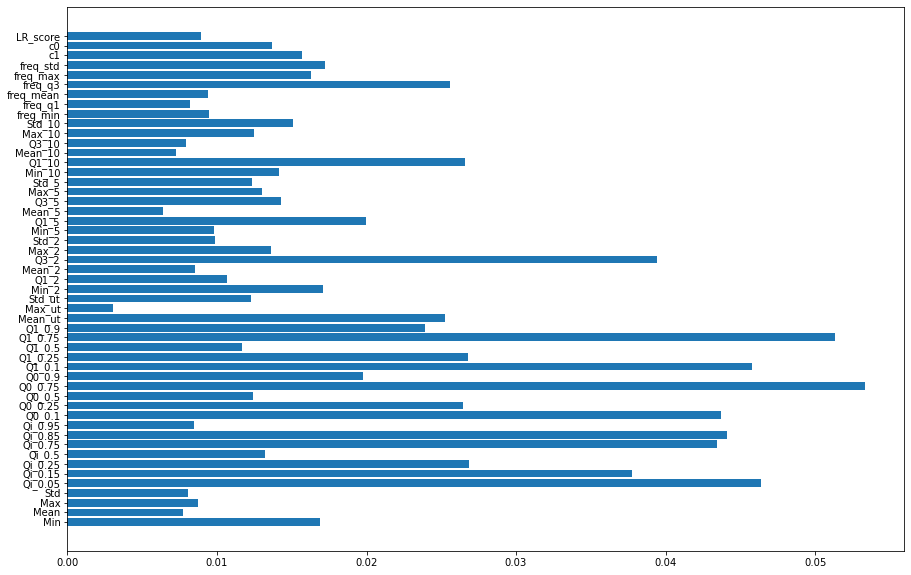

In [69]:
plt.figure(figsize=(15, 10))
use=clf.feature_importances_
feat = list(x_train)
p = plt.barh(feat,use)

In [70]:
df=pd.DataFrame(use ,index=feat, columns=["Use"])
df.sort_values("Use",axis=0,ascending=False, inplace=True)
df.head(10)

,Use
Q0_0.75,0.053312
Q1_0.75,0.051323
Qi_0.05,0.046369
Q1_0.1,0.045777
Qi_0.85,0.044089
Q0_0.1,0.043727
Qi_0.75,0.043437
Q3_2,0.039410
Qi_0.15,0.037739
Qi_0.25,0.026823


In [15]:
df.tail(10)

,Use
Q3_10,0.011282
Mean,0.011141
Q1_0.9,0.010924
freq_q1,0.010718
Mean_2,0.010637
Std,0.010355
Mean_5,0.009766
Mean_10,0.009450
Q0_0.9,0.005623
Max_ut,0.004297


## ExtraTreesClassifier

Meilleur score Xtest : 0.324739812206757

Paramètres : n_estimators = 50, max_depth = 12, min_samples_split = 10, criterion='gini', class_weight={0:1,1:3}

In [14]:
pgrid = {"n_estimators": [50, 75, 100, 200],
    "max_depth": [7, 8, 9, 10,12, 15],
    "min_samples_split": [2, 3, 5, 10],
    "criterion": ["gini","entropy"]}

grid_search = GridSearchCV(ExtraTreesClassifier(class_weight={0:1,1:3}), param_grid=pgrid, cv=5,scoring=make_scorer(cohen_kappa_score), n_jobs=-1)
grid_search.fit(x_train,y_train.values.ravel())
best_clf = grid_search.best_estimator_
print("Best score cv :",grid_search.best_score_)
print("Parametres :",grid_search.best_params_)

best_pred = best_clf.predict(x_test)
score_test = cohen_kappa_score(y_test,best_pred)
print("Score Test :",score_test)
print(f"(TP,FP,TN,FN) : {result(y_test,best_pred)}")

Best score cv : 0.3143689056357318
Parametres : {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 75}
Score Test : 0.34469954602985886
(TP,FP,TN,FN) : (290, 322, 2375, 340)


In [52]:
clf = ExtraTreesClassifier(n_estimators = 50, max_depth = 12, min_samples_split = 10, criterion='gini',  class_weight={0:1,1:3}, n_jobs=-1)
clf.fit(x_train,y_train.values.ravel())
pred = clf.predict(x_test)
score = cohen_kappa_score(y_test,pred)
print(f"cohen kappa score : {score}")
print(f"(TP,FP,TN,FN) : {result(y_test,pred)}")

cohen kappa score : 0.30499591040616925
(TP,FP,TN,FN) : (282, 330, 2324, 391)


In [54]:
use = clf.feature_importances_
feat = list(x_train)
df = pd.DataFrame(use ,index=feat, columns=["Use"])
df.sort_values("Use",axis=0,ascending=False, inplace=True)
df.head(10)

,Use
Q1_0.75,0.059910
Qi_0.85,0.054767
Q0_0.1,0.048854
Q0_0.75,0.048189
Qi_0.15,0.040068
Qi_0.75,0.038687
Q1_0.1,0.035815
Q3_2,0.034177
Qi_0.05,0.031179
Q1_10,0.030316


Les variables les plus discriminantes sont identiques à celle de la fonction RandomForest

## AdaBoost

Pas de test sur Xtest car score de validation croisée et score sur x_test trop faible

In [129]:
pgrid = {"n_estimators": [50, 100, 150, 200],
        "learning_rate":np.linspace(0.1,1,10)}

grid_search = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(class_weight={0: 1, 1: 3})), param_grid=pgrid, cv=5,scoring=make_scorer(cohen_kappa_score), n_jobs=-1)
grid_search.fit(x_train,y_train.values.ravel())
print("Best score cv :",grid_search.best_score_)
print("Parametres :",grid_search.best_params_)


best_clf = grid_search.best_estimator_
best_pred = best_clf.predict(x_test)
score_test = cohen_kappa_score(y_test,best_pred)
print("Score Test :",score_test)
print(f"(TP,FP,TN,FN) : {result(y_test,best_pred)}")

Best score cv : 0.15960921486726415
Parametres : {'learning_rate': 0.1, 'n_estimators': 100}
Score Test : 0.16177092894479428


In [45]:
clf = AdaBoostClassifier(DecisionTreeClassifier(class_weight={0: 1, 1: 3}), learning_rate = 0.5 , n_estimators = 150)
clf.fit(x_train,y_train.values.ravel())
pred = clf.predict(x_test)
score = cohen_kappa_score(y_test,pred)
print(f"cohen kappa score : {score}")
print(f"(TP,FP,TN,FN) : {result(y_test,pred)}")

cohen kappa score : 0.15162958417693628
(TP,FP,TN,FN) : (189, 423, 2289, 426)


## Gradient Boosting

Pas de test sur Xtest car score de validation croisée et score sur x_test trop faible

In [ ]:
pgrid = {"n_estimators": [ 50, 75, 100, 200],
        "max_depth": [6, 7, 8, 9, 10],
        "min_samples_split": [2, 3, 5, 10],
        "learning_rate":[0.1,0.25,0.5,0.75,1.]}

grid_search = GridSearchCV(GradientBoostingClassifier(loss='deviance'), param_grid=pgrid, cv=5,scoring=make_scorer(cohen_kappa_score), n_jobs=-1)
grid_search.fit(x_train,y_train.values.ravel())
print("Best score cv :",grid_search.best_score_)
print("Parametres :",grid_search.best_params_)


best_clf = grid_search.best_estimator_
best_pred = best_clf.predict(x_test)
score_test = cohen_kappa_score(y_test,best_pred)
print("Score Test :",score_test)
print(f"(TP,FP,TN,FN) : {result(y_test,best_pred)}")

In [48]:
clf=GradientBoostingClassifier(loss='deviance',n_estimators = 75  ,max_depth = 10 , min_samples_split = 3,learning_rate=0.2)
clf.fit(x_train,y_train.values.ravel())
pred=clf.predict(x_test)
score=cohen_kappa_score(y_test,pred)
print(f"cohen kappa score : {score}")
print(f"(TP,FP,TN,FN) : {result(y_test,pred)}")

cohen kappa score : 0.2311343395018931


## Réseau de neurones

In [3]:
from collections import defaultdict
import warnings
from sklearn import metrics
import numpy as np

warnings.filterwarnings("ignore", category=RuntimeWarning)

def result2(y_test,pred):
    P = np.where(y_test==1)[0]
    N = np.where(y_test==0)[0]
    TP = len(np.where(pred[P]==1)[0])/len(y_test)
    FP = len(np.where(pred[P]==0)[0])/len(y_test)
    TN = len(np.where(pred[N]==0)[0])/len(y_test)
    FN = len(np.where(pred[N]==1)[0])/len(y_test)
    return (TP,FP,TN,FN)

# Présentation de différents scores en fonction du seuil de probabilité utilisé
def model_seuil(y_prob,y_test,
                metrics=["TP","FP","TN","FN","CKS"]) :
    seuils = np.arange(0,11)/10
    res = defaultdict(list)
    for s in seuils :
        y_pred = y_prob.copy()
        y_pred[y_prob>s]=1
        y_pred[y_prob<=s]=0
        mod_metrics = {}
        mod_metrics["TP"],mod_metrics["FP"],mod_metrics["TN"],mod_metrics["FN"] = result2(y_test,y_pred)
        mod_metrics["CKS"] = cohen_kappa_score(y_test,y_pred)
        for key in metrics :
            res[key].append(mod_metrics[key])
    plt.figure(figsize=(10, 8))
    for key,val in res.items() :
        plt.plot(seuils,val,label=key)
    plt.xlabel("Seuil de probabilité")
    plt.legend(loc="upper left")
    plt.show()

def model_res(model,s,x_train,y_train,x_test,y_test=None,test=True) :
    y_probs_train = model.predict(x_train)
    y_predtrain = np.zeros((x_train.shape[0],1),dtype=int)
    y_predtrain[y_probs_train>s] = 1

    print("Score train :",cohen_kappa_score(y_train,y_predtrain))

    y_probs = model.predict(x_test)
    y_pred = np.zeros((x_test.shape[0],1),dtype=int)
    y_pred[y_probs>s] = 1
    
    if test :
        print("Score test :",cohen_kappa_score(y_test,y_pred))
    
    else :
        df = pd.DataFrame({"Target":y_pred.ravel()},index=x_test.index)
        print(df['Target'].value_counts())
        return(df)

In [4]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

def make_model(input_shape) :
    model = keras.Sequential([
            keras.layers.Dense(120, activation='relu',input_shape=[input_shape]),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(1, activation='sigmoid'),
          ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=tfa.metrics.CohenKappa(num_classes=2, sparse_labels=True)
    )
    
    return model

In [5]:
model = make_model(x_train.shape[1])
model.fit(x_train,y_train,
          batch_size=200,
          epochs=100,
          validation_split=0.1,
          class_weight={0:1,1:5},
          verbose=3)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

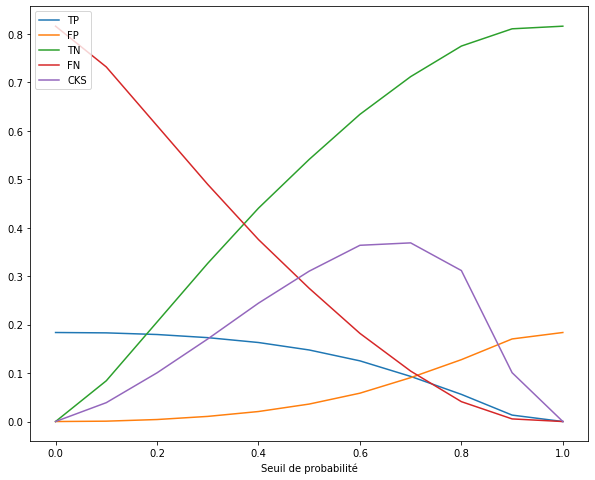

In [6]:
model_seuil(model.predict(x_train),y_train)

Le réseau de neurone donne en sortie la probabilité d'appartenir à la classe 1. La décision de classification se fera vis à vis d'un seuil s tel que si la probabilité est plus grande que s, on classe en 1, sinon en 0. On voit que pour ce modèle, le Cohen Kappa score est meilleure avec un seuil égal à 0.7.

In [7]:
model_res(model,0.7,x_train,y_train,x_test,y_test)

Score train : 0.3688342177448407
Score test : 0.3393587637411227


In [8]:
model = make_model(X_train.shape[1])
model.fit(X_train,Ytrain,
          batch_size=200,
          epochs=100,
          validation_split=0.1,
          class_weight={0:1,1:5},
          verbose=0)

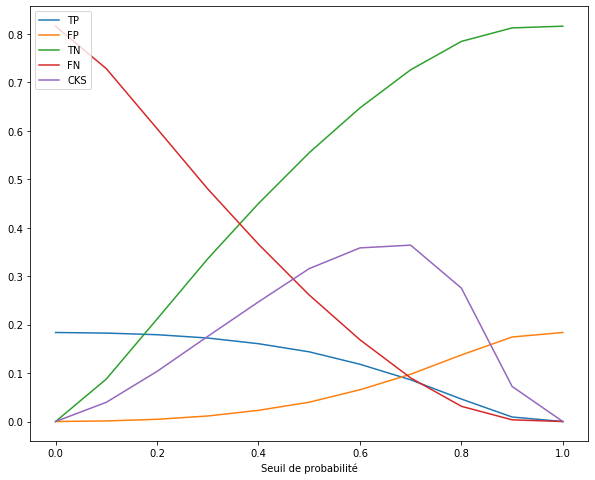

In [9]:
model_seuil(model.predict(X_train),Ytrain)

In [10]:
df = model_res(model,0.7,X_train,Ytrain,X_test,test=False)

Score train : 0.3641314926561686
0    9926
1    2043
Name: Target, dtype: int64


Score pour X_test à 0.31

# Test module imblearn

In [3]:
from imblearn.over_sampling import SMOTE, SVMSMOTE

# Smote

Creation d'individu supplementaire dans la classe 1 à l'aide de la fonction SMOTE

In [17]:
sm = SMOTE()
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

# Random Forest

Meilleur score Xtest : 0.24839463158552588
RandomForestClassifier(n_estimators = 100 ,max_depth = 10, min_samples_split = 2,criterion='gini')

Entrainement sur le nouveau jeu de données

In [81]:
pgrid = {"n_estimators": [50, 100, 150, 200],
    "max_depth": [ 7, 8, 9, 10],
    "min_samples_split": [2, 3, 5, 7, 10],
    "criterion": ["gini","entropy"]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=pgrid, cv=5,scoring=make_scorer(cohen_kappa_score), n_jobs=-1)
grid_search.fit(x_train_sm,y_train_sm.values.ravel())
best_clf = grid_search.best_estimator_
print("Best score cv :",grid_search.best_score_)
print("Parametres :",grid_search.best_params_)

best_pred = best_clf.predict(x_test)
score_test = cohen_kappa_score(y_test,best_pred)
print("Score Test :",score_test)
print(f"(TP,FP,TN,FN) : {result(y_test,best_pred)}")

Best score cv : 0.5831346476195651
Parametres : {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 150}
Score Test : 0.2967765601732404
(TP,FP,TN,FN) : (403, 209, 1994, 721)


In [20]:
clf = RandomForestClassifier(n_estimators = 150 ,max_depth = 10, min_samples_split = 3,criterion='gini', n_jobs=-1)
clf.fit(x_train_sm,y_train_sm.values.ravel())
pred = clf.predict(x_test)
score = cohen_kappa_score(y_test,pred)
print(f"cohen kappa score : {score}")
print(f"(TP,FP,TN,FN) : {result(y_test,pred)}")

cohen kappa score : 0.30544393202501563
(TP,FP,TN,FN) : (356, 256, 2135, 580)


# SVMSmote

In [62]:
svmsm = SVMSMOTE()
x_train_svmsm, y_train_svmsm = svmsm.fit_resample(x_train, y_train)

# Random Forest

In [24]:
pgrid = {"n_estimators": [50, 100, 150, 200],
    "max_depth": [ 7, 8, 9, 10],
    "min_samples_split": [2, 3, 5, 7, 10],
    "criterion": ["gini","entropy"]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=pgrid, cv=5,scoring=make_scorer(cohen_kappa_score), n_jobs=-1)
grid_search.fit(x_train_svmsm,y_train_svmsm.values.ravel())
best_clf = grid_search.best_estimator_
print("Best score cv :",grid_search.best_score_)
print("Parametres :",grid_search.best_params_)

best_pred = best_clf.predict(x_test)
score_test = cohen_kappa_score(y_test,best_pred)
print("Score Test :",score_test)
print(f"(TP,FP,TN,FN) : {result(y_test,best_pred)}")

Best score cv : 0.651351644620316
Parametres : {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 50}
Score Test : 0.3194808925097593
(TP,FP,TN,FN) : (320, 292, 2255, 460)


In [80]:
clf = RandomForestClassifier(n_estimators = 50 ,max_depth = 10, min_samples_split = 3,criterion='gini', n_jobs=-1)
clf.fit(x_train_svmsm,y_train_svmsm.values.ravel())
pred = clf.predict(x_test)
score = cohen_kappa_score(y_test,pred)
print(f"cohen kappa score : {score}")
print(f"(TP,FP,TN,FN) : {result(y_test,pred)}")

cohen kappa score : 0.29643185787688187
(TP,FP,TN,FN) : (282, 330, 2308, 407)


## Prediction X_test

In [27]:
pred =best_clf.predict(X_test)
dfY = pd.DataFrame(pred, index=X_test.index, columns=["Target"])
dfY.to_csv(f"pred/Ytest.csv",sep=',',header=True)